In [86]:
import copy

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tqdm import tqdm
import torch

from utils.options import args_parser
from utils.utils import exp_details, get_train_test, get_model, get_dataset_and_label_names, add_noise
from utils.update import LocalUpdate
from utils.sampling import dominant_label_sampling, dirichlet_sampling

In [87]:
args = args_parser(default=True)

args.local_ep = 5
args.local_bs = 32
args.lr = 1e-4
args.supervision = True
args.num_users = 100

exp_details(args)


Experimental details:

Reinforcement Arguments:
    Steps Before PPO Update : 256
    PPO Learning Rate       : 0.0003
    PPO Discount Factor     : 0.9
    PPO Batch Size          : 16
    PPO Total Timesteps     : 15000
    Target Accuracy         : 0.95

Federated Arguments:
    Number of Users         : 100
    Fraction of Users       : 0.1
    Local Epochs            : 5
    Local Batch Size        : 32
    Learning Rate           : 0.0001
    Momentum                : 0.5
    Optimizer               : adam

Model Arguments:
    Supervision             : True
    Architecture            : cnn

Misc. Arguments:
    Dataset                 : mnist
    Number of GPUs          : 1
    IID                     : 0
    Random Seed             : 1
    Test Fraction           : 1
    Save Path               : ../../save
    Data Path               : ../../data



In [88]:
plt.style.use("seaborn-darkgrid")
%config InlineBackend.figure_format = 'svg'

In [89]:
def train_local_models(dataset, arch, sampling_type, save_layers=None, supervision=True, model=None, noise_type="gaussian", noise_scale=0):
    
    dataset_dir = None
    if dataset == "imagenet":
        dataset_dir = "/lus/theta-fs0/software/datascience/ImageNet/ILSVRC/Data/CLS-LOC"
        
    train_dataset, _ = get_train_test(dataset, dataset_dir=dataset_dir)

    base_model = get_model(arch, dataset, "cuda")
    local_models = [copy.deepcopy(base_model) for _ in range(args.num_users)]

    if sampling_type == "dominant_label":
        dict_users = dominant_label_sampling(train_dataset, num_users=args.num_users, sample_ratio=0.01 if dataset == "imagenet" else 0.8, num_labels=30 if dataset == "imagenet" else 10, gamma=0.8, print_labels=False)
    if sampling_type == "dirichlet":
        dict_users = dirichlet_sampling(train_dataset, num_users=args.num_users, sample_ratio=0.6, alpha=0.2, print_labels=False)

    print("Training client fitting models...")
    user_params = []
    user_labels = []
    for i, user_samples in tqdm(dict_users.items()):
        local_model = local_models[i]
        local_update = LocalUpdate(
            train_dataset,
            user_samples,
            args.local_ep,
            args.local_bs,
            args.lr,
            args.optimizer,
            supervision,
            "cuda",
        )
        local_update.update_weights(local_model)
        add_noise(local_model.state_dict(), noise_type=noise_type, scale=noise_scale)
        
        if save_layers is None:
            params = torch.cat([p.flatten() for p in local_model.parameters()]).detach().cpu().numpy()
        else:
            params = []
            for layer in save_layers:
                layer_params = local_model.__dict__["_modules"][layer].parameters()
                layer_params_flat = torch.cat([p.flatten() for p in layer_params]).detach().cpu().numpy()
                params.append(layer_params_flat)
        
        labels = np.array(train_dataset.targets)[list(user_samples)]
        user_params.append(params)
        user_labels.append(labels)

    return user_params, user_labels


def plot_pca(dataset, sampling_type, user_params, user_labels, layer=None, model=None, noise_type="gaussian", noise_scale=0):
    
    pca = PCA(n_components=2)
    user_params_pca = pca.fit_transform(user_params)
    print(f"Variance Explained: {100 * sum(pca.explained_variance_ratio_):.1f} %")
    dominant_label_idxs = [stats.mode(labels).mode[0] for labels in user_labels] 
    dominant_label_ratios = np.array([stats.mode(labels).count[0] / len(labels) for labels in user_labels])
    
    # Set up sizes
    if sampling_type == "dirichlet":
        min_ratio = min(dominant_label_ratios)
        max_ratio = max(dominant_label_ratios)
        sizes = 150 * (dominant_label_ratios - min_ratio) / max_ratio
    else:
        sizes = [50 for _ in user_labels]
    
    # Set up colors and markers
    cmap = plt.cm.get_cmap('tab10')
    colors = [cmap(idx) for idx in dominant_label_idxs]
    
    marker_map = np.array(["v", "^", "<", ">", "s", "p", "P", "*", "X", "D"])
    markers = [marker_map[idx] for idx in dominant_label_idxs]
    
    # Plot points
    fig, ax = plt.subplots()
    for (x, y), m, c, s in list(zip(user_params_pca, markers, colors, sizes)):
        ax.scatter(x, y, marker=m, color=c, s=s)
        
    # Set plot title
    dataset_name, label_names = get_dataset_and_label_names(dataset)
    dominant_label_names = label_names[dominant_label_idxs]
    
    if sampling_type == "dirichlet":
        sampling_type_name = "Dirichlet"
    elif sampling_type == "dominant_label":
        sampling_type_name = "80%-20%"
    
    title = f"{dataset_name} Client Models, {sampling_type_name} Sampling"
    if layer is not None:
        title += ', ' + layer
    if model is not None:
        title += ', ' + model
    if noise_scale != 0:
        title += ', ' + noise_type.title() + " Noise, " + f"{noise_scale:.0e}"
    ax.set_title(title)

    # Set up legend
    legend_handles = [plt.Line2D([], [], marker=marker, markersize=10, color=color, linestyle='None', label=label)
                      for label, marker, color in zip(label_names, [marker_map[i] for i in range(10)], [cmap(i) for i in range(10)])]
    legend = ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), title="Dominant Label")
    legend._legend_box.align = "left"
    
    plt.savefig(f"{dataset}_{sampling_type}.svg", bbox_inches='tight')
    
    
def plot_pca_layers(dataset, sampling_type, all_user_params, all_user_labels, layers=None, model=None, noise_type="gaussian", noise_scale=0):
    
    fig, axs = plt.subplots(3, 2, figsize=(6, 9))
    
    for i, ax in enumerate(axs.flatten()):
        
        if i >= len(all_user_params[0]):
            ax.set_visible(False)
            continue
            
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
        user_params = [param[i] for param in all_user_params]
        
        pca = PCA(n_components=2)
        user_params_pca = pca.fit_transform(user_params)
        print(f"Variance Explained: {100 * sum(pca.explained_variance_ratio_):.1f} %")
        dominant_label_idxs = [stats.mode(labels).mode[0] for labels in user_labels] 
        dominant_label_ratios = np.array([stats.mode(labels).count[0] / len(labels) for labels in user_labels])
        
        # Set up sizes
        if sampling_type == "dirichlet":
            min_ratio = min(dominant_label_ratios)
            max_ratio = max(dominant_label_ratios)
            sizes = 150 * (dominant_label_ratios - min_ratio) / max_ratio
        else:
            sizes = [50 for _ in user_labels]

        # Set up colors and markers
        cmap = plt.cm.get_cmap('tab10')
        colors = [cmap(idx) for idx in dominant_label_idxs]

        marker_map = np.array(["v", "^", "<", ">", "s", "p", "P", "*", "X", "D"])
        markers = [marker_map[idx] for idx in dominant_label_idxs]

        # Plot points
        for (x, y), m, c, s in list(zip(user_params_pca, markers, colors, sizes)):
            ax.scatter(x, y, marker=m, color=c, s=s)
            
        ax.set_title(layers[i])

    # Set plot title
    dataset_name, label_names = get_dataset_and_label_names(dataset)
    dominant_label_names = label_names[dominant_label_idxs]

    if sampling_type == "dirichlet":
        sampling_type_name = "Dirichlet"
    elif sampling_type == "dominant_label":
        sampling_type_name = "80%-20%"

    title = f"{dataset_name} Client Models, {sampling_type_name} Sampling, Layer-by-Layer"
    fig.suptitle(title)
    fig.tight_layout()

    # Set up legend
    legend_handles = [plt.Line2D([], [], marker=marker, markersize=10, color=color, linestyle='None', label=label)
                      for label, marker, color in zip(label_names, [marker_map[i] for i in range(10)], [cmap(i) for i in range(10)])]
    legend = axs.flatten()[len(all_user_params[0]) - 1].legend(handles=legend_handles, bbox_to_anchor=(1.75, 1), loc="upper right", title="Dominant Label")
    legend._legend_box.align = "left"

    plt.savefig(f"{dataset}_{sampling_type}_layers.svg", bbox_inches='tight')

## Basic Experiments: Dominant-Label and Dirichlet Sampling

Training client fitting models...


100%|██████████| 100/100 [00:23<00:00,  4.24it/s]


Variance Explained: 30.3 %


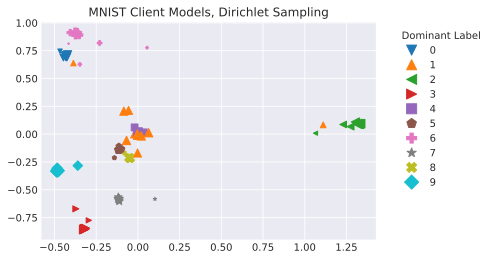

In [92]:
user_params, user_labels = train_local_models("mnist", "mlp", "dirichlet")
plot_pca("mnist", "dirichlet", user_params, user_labels)

Training client fitting models...


100%|██████████| 100/100 [00:29<00:00,  3.39it/s]


Variance Explained: 32.6 %


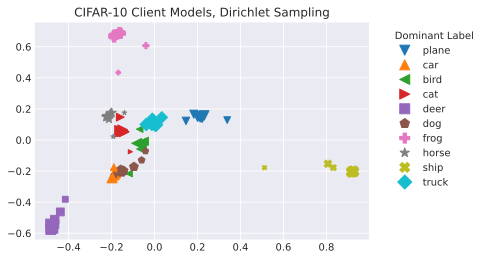

In [91]:
user_params, user_labels = train_local_models("cifar", "cnn", "dirichlet")
plot_pca("cifar", "dirichlet", user_params, user_labels)

Performing client sampling...


100%|██████████| 100/100 [00:00<00:00, 481.53it/s]


Training client fitting models...


100%|██████████| 100/100 [00:31<00:00,  3.13it/s]


Variance Explained: 27.8 %


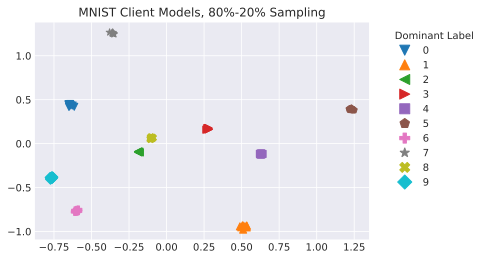

In [102]:
user_params, user_labels = train_local_models("mnist", "mlp", "dominant_label")
plot_pca("mnist", "dominant_label", user_params, user_labels)

Performing client sampling...


100%|██████████| 100/100 [00:00<00:00, 562.89it/s]


Training client fitting models...


100%|██████████| 100/100 [00:38<00:00,  2.59it/s]


Variance Explained: 30.0 %


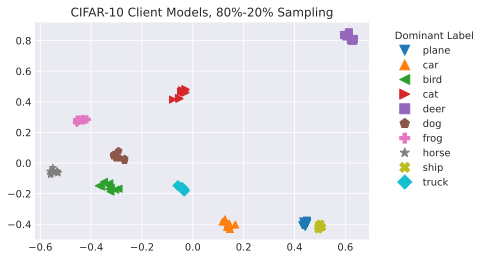

In [99]:
user_params, user_labels = train_local_models("cifar", "cnn", "dominant_label")
plot_pca("cifar", "dominant_label", user_params, user_labels)

## Gaussian and Laplacian Noise

In [ ]:
user_params, user_labels = train_local_models("mnist", "mlp", "dominant_label", noise_type="gaussian", noise_scale=1e-4)
plot_pca("mnist", "dominant_label", user_params, user_labels, noise_type="gaussian", noise_scale=1e-4)

In [ ]:
user_params, user_labels = train_local_models("mnist", "mlp", "dominant_label", noise_type="gaussian", noise_scale=1e-3)
plot_pca("mnist", "dominant_label", user_params, user_labels, noise_type="gaussian", noise_scale=1e-3)

In [ ]:
user_params, user_labels = train_local_models("mnist", "mlp", "dominant_label", noise_type="gaussian", noise_scale=1e-2)
plot_pca("mnist", "dominant_label", user_params, user_labels, noise_type="gaussian", noise_scale=1e-2)

In [ ]:
user_params, user_labels = train_local_models("mnist", "mlp", "dominant_label", noise_type="laplacian", noise_scale=1e-4)
plot_pca("mnist", "dominant_label", user_params, user_labels)

In [ ]:
user_params, user_labels = train_local_models("mnist", "mlp", "dominant_label", noise_type="laplacian", noise_scale=1e-3)
plot_pca("mnist", "dominant_label", user_params, user_labels)

In [ ]:
user_params, user_labels = train_local_models("mnist", "mlp", "dominant_label", noise_type="laplacian", noise_scale=1e-2)
plot_pca("mnist", "dominant_label", user_params, user_labels)

## Layer-by-layer Analysis

In [54]:
layers = ["conv1", "conv2", "conv3", "fc1", "fc2"]
user_params, user_labels = train_local_models("cifar", "cnn", "dominant_label", save_layers=layers)

Performing client sampling...


100%|██████████| 100/100 [00:00<00:00, 578.91it/s]


Training client fitting models...


100%|██████████| 100/100 [00:39<00:00,  2.50it/s]


Variance Explained: 51.4 %
Variance Explained: 43.5 %
Variance Explained: 33.1 %
Variance Explained: 27.9 %
Variance Explained: 25.1 %


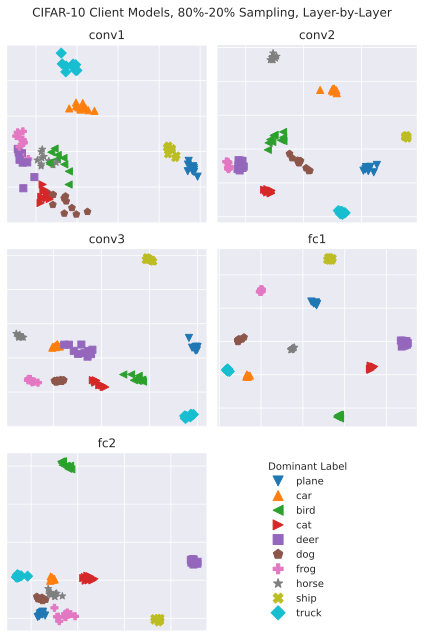

In [85]:
plot_pca_layers("cifar", "dominant_label", user_params, user_labels, layers=layers)

Performing client sampling...


100%|██████████| 100/100 [00:00<00:00, 497.18it/s]


Training client fitting models...


100%|██████████| 100/100 [00:37<00:00,  2.69it/s]


Variance Explained: 39.4 %


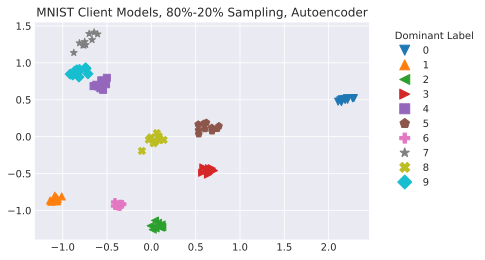

In [17]:
user_params, user_labels = train_local_models("mnist", "autoencoder", "dominant_label", supervision=False)
plot_pca("mnist", "dominant_label", user_params, user_labels, "Autoencoder")

In [ ]:
# args.local_ep = 1
# args.num_users = 100
# user_params, user_labels = train_local_models("imagenet", "resnet", "dominant_label", save_layers=["conv1", "layer1", "layer2", "layer3", "layer4"])
for i in range(5):
    params = [param[i] for param in user_params]
    plot_pca("imagenet", "dominant_label", params, user_labels)
    plt.show()

In [ ]:
args.local_ep = 5
args.num_users = 100
user_params, user_labels = train_local_models("imagenet", "resnet", "dominant_label", save_layers=["conv1", "layer1", "layer2", "layer3", "layer4"])
for i in range(5):
    params = [param[i] for param in user_params]
    plot_pca("imagenet", "dominant_label", params, user_labels)
    plt.show()